In [1]:
import block
import importlib
import dataloader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import cv2
import numpy as np
import gc
import loss
import train
import test
import utils

c:\Users\Tawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(dataloader)
importlib.reload(block)
importlib.reload(loss)
importlib.reload(train)
importlib.reload(test)
importlib.reload(utils)

<module 'utils' from 'd:\\Documents\\machinelearning\\SIR\\ShallowFE\\utils.py'>

In [3]:
from dataloader import ImageDataset, ImageLoader

dataset = ImageDataset("../data/")
loader = ImageLoader(dataset, batch_size=1)

In [4]:
test_loader, train_loader = ImageLoader(dataset[2000:], batch_size=1), ImageLoader(
    dataset[:2000], batch_size=1
)

**Test Image**

In [5]:
img = loader.dataset[2049]

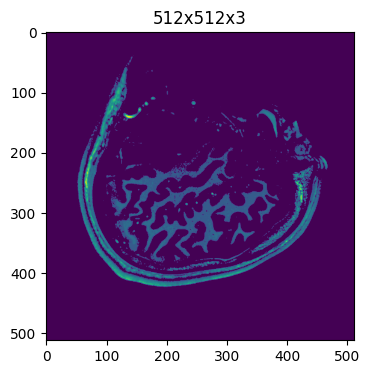

In [6]:
plt.figure(figsize=(6, 4))
plt.title("512x512x3")
plt.imshow(img[0][0])
plt.show()

In [7]:
prev_params = None
for size in [128, 256]:
    fe = block.ShallowFE(img.shape[1], size)
    num_params = sum(p.numel() for p in fe.parameters())
    if prev_params is not None:
        increase_percent = ((num_params - prev_params) / prev_params) * 100
        print(
            f"Number of parameters for output size {size}: {num_params:,} (+{increase_percent:.2f}%)"
        )
    else:
        print(f"Number of parameters for output size {size}: {num_params:,}")
    prev_params = num_params

del fe
gc.collect()
torch.cuda.empty_cache()

Number of parameters for output size 128: 4,095,199
Number of parameters for output size 256: 16,283,679 (+297.63%)


In [8]:
block.ShallowFE(img.shape[1], 256)

ShallowFE(
  (L1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
  )
  (MDB): MultiDilationBlock(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
        (1): BatchNorm2d(128, eps=1e-05, mo

In [9]:
TRAIN, TEST, EVAL = True, False, False
if TRAIN:
    for size in [128]:
        fe = block.ShallowFE(img.shape[1], size)
        optimizer = optim.Adam(fe.parameters(), lr=0.00001)
        train.train(fe, train_loader, loss.VGGPerceptualLoss(), optimizer, size, 5, iter=100)
        gc.collect()
        torch.cuda.empty_cache()

c:\Users\Tawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training is True
Epoch:1


0it [00:00, ?it/s]c:\Users\Tawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\Tawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
15it [00:12,  1.68it/s]

In [ ]:
if TEST:
    for size in [64, 256]:
        plt.figure(figsize=(32, 6))
        plt.subplot(1, 7, 1)
        plt.title(f"{size}: Original")
        plt.imshow(img[0][0])
        for epoch in range(3, 9):
            plt.subplot(1, 7, epoch - 1)
            plt.title(f"{size}: {"Epoch" + str(epoch - 3) if epoch < 8 else 'Untrained'}")
            fe = block.ShallowFE(img.shape[1], size)
            if epoch >= 0 and epoch < 8:
                fe.load_state_dict(torch.load(f"./models/model({size})_{epoch - 3}.pth"))
            fe.eval()
            #test.test(fe, test_loader)
            plt.imshow(fe(img)[0][0].detach().cpu().numpy())
            torch.cuda.empty_cache()
            gc.collect()
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './models/model(128)_0.pth'

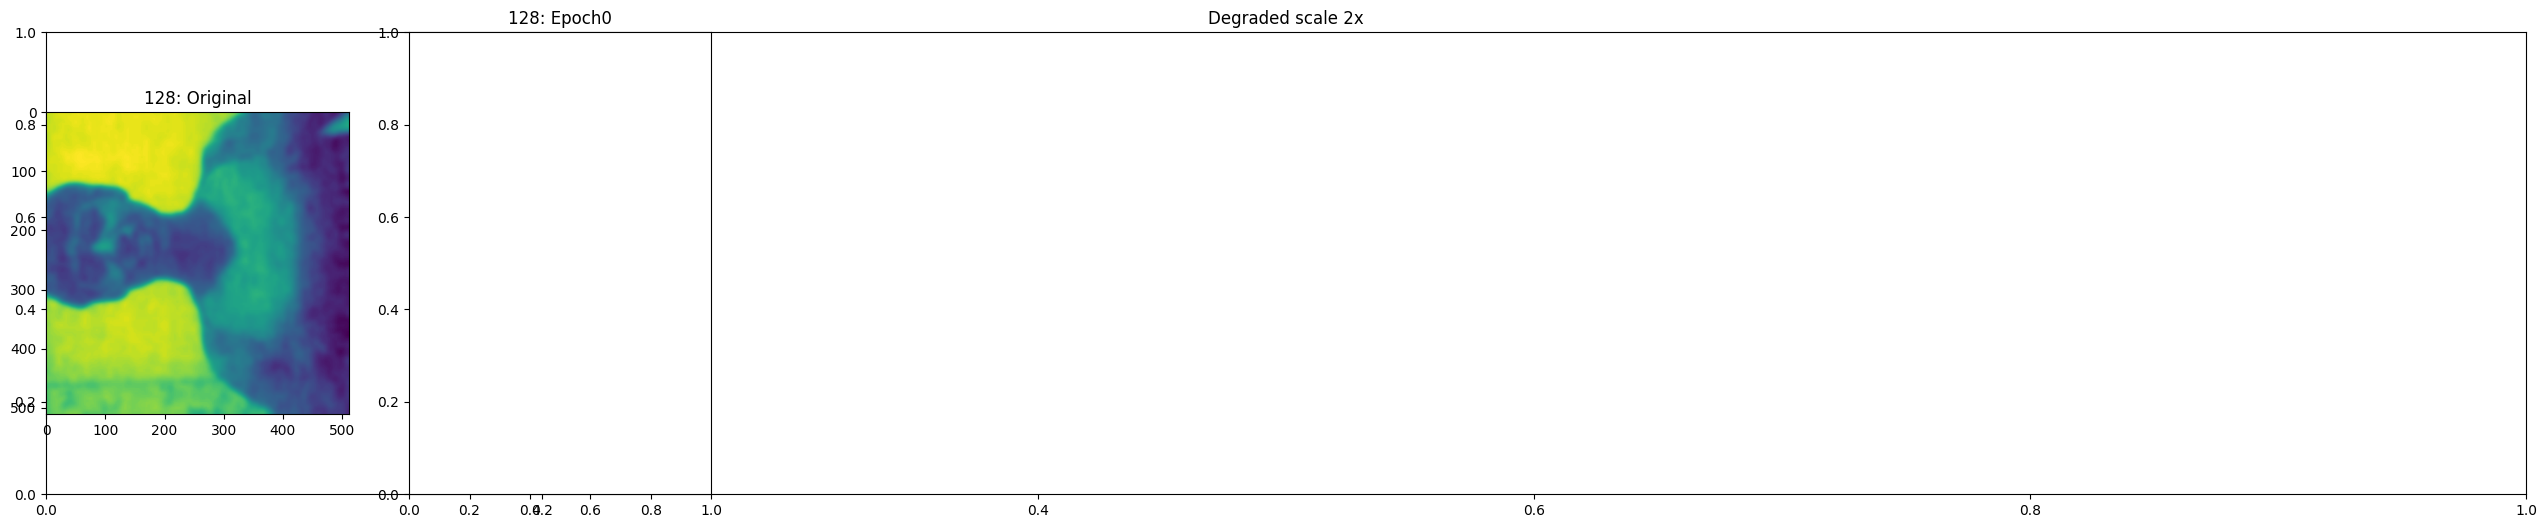

In [ ]:
if EVAL:
    for res in range(2, 5):
        transform = transforms.Compose([utils.DecreaseResolution(3, depth = res)])
        copied = img.clone()
        copied[0] = transform(copied)
        for size in [128]:
            plt.figure(figsize=(32, 6))
            plt.title(f"Degraded scale {res}x")
            plt.subplot(1, 7, 1)
            plt.title(f"{size}: Original")
            plt.imshow(copied[0][0])
            for epoch in range(3, 9):
                plt.subplot(1, 7, epoch - 1)
                plt.title(f"{size}: {"Epoch" + str(epoch - 3) if epoch < 8 else 'Untrained'}")
                fe = block.ShallowFE(copied.shape[1], size)
                
                if epoch >= 0 and epoch < 8:
                    fe.load_state_dict(torch.load(f"./models/model({size})_{epoch - 3}.pth"))
                fe.eval()
 
                #test.test(fe, test_loader)
                
                out = copied.clone()
 
                out = fe(out)

                plt.imshow(out[0][0].detach().cpu().numpy())

                torch.cuda.empty_cache()
                gc.collect()
            plt.show()